Instalando os modulos nescessários


In [ ]:
!pip install -q  torchtext
!pip install -q pytorch-nlp



     |████████████████████████████████| 92kB 5.5MB/s 


Download dataset

In [ ]:
!wget -q --no-check-certificate \
    "https://www.dropbox.com/s/3imrfuur3is3hn2/chennai_reviews.csv?dl=0" \
    -O "/tmp/chennai_reviews.csv"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchnlp
from torchnlp.encoders.text import SpacyEncoder, pad_tensor
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm


SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


TRATANDO DATASET

In [ ]:
df = pd.read_csv('/tmp/chennai_reviews.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
values = {'Hotel_name': 'Unavailable', 'Review_Title': 'Unavailable', 'Review_Text': 'Unavailable'}
df = df.fillna(value=values)


In [ ]:
#Replace noisy data in column Sentiment and Rating_Percentage with column mean value
df['Sentiment'] = df['Sentiment'].str.replace(r'[^0-9]','')
df['Rating_Percentage'] = df['Rating_Percentage'].str.replace(r'[^0-9]+','')

#Remove white spaces
df['Sentiment'] = df['Sentiment'].str.replace(r'[s+]','')

#Fill missing values
df['Sentiment'] = df['Sentiment'].fillna(2)
df['Rating_Percentage'] = df['Rating_Percentage'].fillna(72)
#classes = df.pop('Sentiment')



In [ ]:
df = df.drop(['Rating_Percentage','Review_Title','Hotel_name'], axis=1)

In [ ]:
df.head()

,Review_Text,Sentiment
0,Its really nice place to stay especially for b...,3
1,It seems that hotel does not check the basic a...,1
2,Worst hotel I have ever encountered. I will ne...,1
3,Had a good time in this hotel and the staff Ku...,3
4,good hotel and staff Veg food good non veg bre...,3


In [ ]:

df['Review_Text'] = df['Review_Text'].apply(lambda x:x.lower())

#set names for beautiful df
df.columns = ['text', 'sentiment']
df['sentiment'].astype(str)

0       3
1       1
2       1
3       3
4       3
       ..
4763    3
4764    3
4765    3
4766    1
4767    3
Name: sentiment, Length: 4768, dtype: object

In [ ]:
df['text'][1]

'it seems that hotel does not check the basic amenities in the room, before handing over the room to the traveller.  the phone in my room was not working and it created a problem for me, as after a hectic day of travel you would like to relax and work at your own pace. so they sent the technician who kept on looking for the fix for about an hour and then i had to get my room changed.'

In [ ]:
n_categories= df['sentiment'].nunique()

CODIFICANDO DATASET

In [ ]:
encoder = SpacyEncoder(df['text'])

#first, encode it
encoded_texts = []
for i in tqdm(range(len(df['text']))):
    encoded_texts.append(encoder.encode(df['text'][i]))

100%|██████████| 4768/4768 [00:00<00:00, 7781.46it/s]


100%|██████████| 4768/4768 [00:00<00:00, 810211.14it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


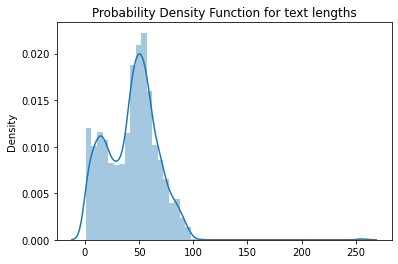

In [ ]:

lengths = [len(i) for i in tqdm(encoded_texts)]

length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
sns.distplot(length_as_series)

max_pad_length = length_as_series.quantile(0.9)

DEFININDO MODELO

In [ ]:
reviews = []
classes = []

for i in tqdm(range(len(encoded_texts))):
    if len(encoded_texts[i]) < max_pad_length:
        reviews.append(encoded_texts[i])
        classes.append(df['sentiment'][i])
        
assert len(reviews) == len(classes), "The labels and feature lists should have the same time"

100%|██████████| 4768/4768 [00:00<00:00, 105948.08it/s]


In [ ]:
for i in range(len(classes)):
  if classes[i] == '':
    classes[i] = 1 
  else: 
    classes[i] = int(classes[i])


In [ ]:
n_classes =3 

In [ ]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)    

In [ ]:
max_pad_length = length_as_series.quantile(0.9)
padded_dataset = []

for i in tqdm(range(len(reviews))):
    padded_dataset.append(pad_tensor(reviews[i], int(max_pad_length)))
    
X = torch.stack(padded_dataset)
y = torch.tensor(classes)
#train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=100)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

100%|██████████| 4289/4289 [00:00<00:00, 45183.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [ ]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
len(reviews[0])

13

In [ ]:
#%debug
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
         
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))


In [ ]:
INPUT_DIM = len(encoder.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 754,805 trainable parameters


In [ ]:

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:

optimizer = optim.Adam(classifier.parameters(), lr=.01)#0.002 dives 85% acc
criterion = 

In [ ]:
encoder.tokenize

functools.partial(<function _tokenize at 0x7f29b177b950>, tokenizer=<spacy.lang.en.English object at 0x7f298fa5f290>)

In [ ]:

epoch_bar = tqdm(range(10),
                 desc="Training",
                 position=0,
                 total=2)

acc = 0

for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(train_loader))
    
    for i, (datapoints, labels) in batch_bar:
        
        optimizer.zero_grad()
        hidden = rnn.initHidden()
        preds = rnn(datapoints,hidden.long())
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
    
        if (i + 1) % 500 == 0:
            
            preds = rnn(X_test,hidden())
            acc = (preds.argmax(dim=1) == y_test).float().mean().cpu().item()

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              accuracy="{:.2f}".format(acc),
                              epoch=epoch)
        batch_bar.update()

        
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          accuracy="{:.2f}".format(acc),
                          epoch=epoch)
    epoch_bar.update()

Epoch: 0:   0%|          | 0/101 [00:00<?, ?it/s]

RuntimeError: ignored